In [2]:
from google.oauth2 import service_account
from googleapiclient.discovery import build
import pandas as pd
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import os
import boto3
import re
import requests
import numpy as np
import json
from apiclient import discovery
from httplib2 import Http
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex
from matplotlib.lines import Line2D
import seaborn as sns
BASE_URL = 'https://sketch.api.agbiome.cloud'
session = boto3.Session(profile_name='prod')
STAGING_BUCKET = os.environ['STAGING_BUCKET']
ATHENA_CURSOR = connect(
    s3_staging_dir=STAGING_BUCKET,
    region_name="us-west-2",
    cursor_class=PandasCursor,
    profile_name="prod"
).cursor()
BASE_URL = 'https://sketch.api.agbiome.cloud'

In [3]:
sm = session.client("secretsmanager")
secret_json = sm.get_secret_value(SecretId="SheetsAndDriveAPIServiceAcctCredentials")[
    "SecretString"
]
secret_data = json.loads(secret_json)
scopes = ["https://www.googleapis.com/auth/spreadsheets"]

creds = service_account.Credentials.from_service_account_info(
    secret_data, scopes=scopes
)
service = build("sheets", "v4", credentials=creds)
sheets = service.spreadsheets()
SHEET_ID="1ECut3HfNYyRcJXvwM3mTueOOchiNNuJN9Qtg2Cs3LzI"

_r="Data!A1:N1921"

In [4]:
chlamy = (
   pd.DataFrame(
       sheets.values()
       .get(spreadsheetId=SHEET_ID, range=_r, majorDimension='ROWS')
       .execute()['values'])
)

In [5]:
chlamy.columns = chlamy.iloc[0]
chlamy.drop(index=[0], inplace=True)
chlamy.head()

,Order,Block,Well,AIM,NameTag,Notebook page,5ul OD750,5ul % of max,1ul Hits (eyeball),5ul hits (<45%)=,Cells/ml,OD<0.13,OD>0.67,Media
1,1,533,A1,AIM050987,none,DJD01-44,0.3134,64%,0,0,2.50E+06,0,0,TSB
2,2,533,B1,AIM050988,Bacillus velezensis,DJD01-44,0.2116,43%,0,1,1.37E+06,0,0,TSB
3,3,533,C1,AIM050989,Chryseobacterium timonianum,DJD01-44,0.1948,40%,0,1,1.19E+06,0,0,TSB
4,4,533,D1,AIM050990,none,DJD01-44,0.3177,65%,0,0,2.55E+06,0,0,TSB
5,5,533,E1,AIM050991,Lysinibacillus sp002237755,DJD01-44,0.3585,73%,0,0,3.01E+06,0,0,TSB


In [6]:
chlamy.loc[~chlamy['Block'].isin(['533B'])].AIM.nunique()

1815

In [8]:
chlamy.Block.unique()

array(['533', '526', '527', '541', '542', '543', '544', '529', '530',
       '548', '546', '555', '532', '537', '531', '533B', '538', '588',
       '1005', '1007'], dtype=object)

In [9]:
chlamy['aim_number'] = chlamy['AIM'].str.strip('AIM').astype(int)
chlamy['plate'] = chlamy.loc[~chlamy['Block'].isin(['533B'])].Block.astype(int)
chlamy.plate.fillna(533, inplace=True)

In [10]:
hitlist = chlamy.loc[chlamy['5ul hits (<45%)= '] == '1'].aim_number.tolist()

In [11]:
stats = f"""
    WITH q AS (
        SELECT c.aim,
                c.asm,
                c.completeness,
                c.contamination,
                c.plate,
                CASE 
                    WHEN g.genus IS NULL
                    THEN 'unknown'
                    ELSE g.genus
                END AS genus,
                CASE
                    WHEN g.binomial IS NULL
                    THEN 'unknown'
                    ELSE g.binomial
                END AS binomial
    FROM genomics.checkm_o2_parquet c
    FULL OUTER JOIN genomics.gtdbtk_parquet g
    ON c.asm = g.asm
    WHERE c.plate IN {tuple(chlamy['plate'].unique().tolist())}
    )
    SELECT * FROM q
     WHERE aim IN {tuple(chlamy['aim_number'].unique().tolist())}
     AND completeness > 80 and contamination < 10
    """
aws_data = ATHENA_CURSOR.execute(stats).as_pandas()

In [99]:
cc = aws_data.groupby('aim').first().reset_index()

In [17]:
asms = [int(i) for i in cc['asm'].tolist()]

In [18]:
resp = requests.post(
            url=f'{BASE_URL}/asms',
            json={'asms': asms}
) 
rsps = resp.json()

In [ ]:
search = requests.post(
    url=f'{BASE_URL}/comparesketch/alltoall',
    json={'queries': rsps}
) 

job_id = search.json()

In [20]:
job_id = {'jobId': 'ad5a1878-d448-4fe4-9110-8cf99d414d1f'}

In [21]:
threshold = 80

query = f'''
    select query, subject, kid 
    from genomics.comparesketch_alltoall 
    where jobid = '{job_id['jobId']}'
          and kid >= {threshold}
'''

def extract_aim(identifier):
    return int(re.search('AIM(\d+)', identifier).group(1))

df_edges = (
    ATHENA_CURSOR.execute(query).as_pandas()
    .assign(aim = lambda df: df['query'].map(extract_aim).astype('Int64'))
    .assign(target_aim = lambda df: df['subject'].map(extract_aim).astype('Int64'))
    .drop(['query', 'subject'], axis=1)
)

In [22]:
df_edges.head()

,kid,aim,target_aim
0,100.000000,51505,51505
1,89.603960,51505,50799
2,89.183170,51505,50930
3,89.942245,51505,50397
4,89.504950,51505,51536


In [23]:
df_edges.aim.nunique()

1415

In [24]:
len(set(df_edges.aim.tolist()) - set(cc.aim.tolist()))

0

In [83]:
sorted_counts = (
    cc[['aim', 'genus']]
    .groupby('genus')
    .count()
    .sort_values('aim', ascending=False)
    .reset_index()
)

In [84]:
sorted_counts.aim.sum()

1415

In [85]:
top15 = sorted_counts.head(15)

In [86]:
combined = sorted_counts.loc[sorted_counts['aim']<10].sum()

In [87]:
other = pd.DataFrame([['other', combined.aim]], columns = ['genus', 'aim'])

In [88]:
final_counts = pd.concat([top15, other])

In [89]:
final_counts

,genus,aim
0,Bacillus_A,778
1,Bacillus_C,195
2,Pseudomonas_E,46
3,Bacillus,40
4,Enterobacter,39
5,Rhodococcus,26
6,Microbacterium,20
7,Arthrobacter_B,18
8,Streptomyces,18
9,Lysinibacillus,17


In [196]:
cmap = get_cmap('tab20')
colordict = {g: to_hex(cmap(i)) for i, g in enumerate(final_counts.genus)}

In [199]:
colordict['other']

'#c7c7c7'

In [217]:
leg_els = [
    Line2D([0], [0], marker='o', color='w', label=f'{k:<17}{sum(cc.genus==k):>4}', markerfacecolor=v, markersize=10)
    for k, v in colordict.items()
]
legend_elements = leg_els[:-1]

In [235]:
legend_elements.append(
    Line2D(
        [0], [0], 
        marker='o', 
        color='w', 
        label=f'{"other":<17}{158:>4}', 
        markerfacecolor=colordict['other'], 
        markersize=10
        )
)

In [36]:
graph_df = df_edges

In [37]:
graph_df.rename(columns={'aim': 'source', 'target_aim': 'target'}, inplace=True)

In [39]:
G = nx.from_pandas_edgelist(graph_df, edge_attr='kid')
G.remove_edges_from(list(nx.selfloop_edges(G)))
assert len(G.nodes) == graph_df.source.nunique()
pos = graphviz_layout(G)

In [70]:
colordict

{'Bacillus_A': '#1f77b4',
 'Bacillus_C': '#aec7e8',
 'Pseudomonas_E': '#ff7f0e',
 'Bacillus': '#ffbb78',
 'Enterobacter': '#2ca02c',
 'Rhodococcus': '#98df8a',
 'Microbacterium': '#d62728',
 'Arthrobacter_B': '#ff9896',
 'Streptomyces': '#9467bd',
 'Lysinibacillus': '#c5b0d5',
 'Bacillus_AW': '#8c564b',
 'Bacillus_X': '#c49c94',
 'Bacillus_W': '#e377c2',
 'Paenibacillus_B': '#f7b6d2',
 'Ochrobactrum_A': '#7f7f7f',
 'other': '#c7c7c7'}

In [205]:
pos_df = (
    pd.DataFrame(pos).T
    .reset_index()
    .rename(columns={'index': 'aim'})
    .merge(cc[['aim', 'genus']], on='aim')
    .assign(color = lambda df: df['genus'].map(colordict))
)

In [206]:
pos_df['color'].fillna('#c7c7c7', inplace=True)

In [207]:
pos_df.head(1)

,aim,0,1,genus,color
0,51505,1430.7,1475.2,Bacillus_A,#1f77b4


In [208]:
for i, r in pos_df.iterrows():
    if r['aim'] in hitlist:
        pos_df.loc[i, 'hit'] = 'yes'
        pos_df.loc[i, 'marker'] = "+"
        pos_df.loc[i, 'back'] = 'black'
        pos_df.loc[i, 'size'] = 300
    else:
        pos_df.loc[i, 'hit'] = 'no'
        pos_df.loc[i, 'marker'] = 'o'
        pos_df.loc[i, 'back'] = '#eeeeee'
        pos_df.loc[i, 'size'] = 200

In [213]:
pos_df.color.unique()

array(['#1f77b4', '#f7b6d2', '#ff7f0e', '#aec7e8', '#c7c7c7', '#98df8a',
       '#ff9896', '#7f7f7f', '#ffbb78', '#d62728', '#c5b0d5', '#c49c94',
       '#8c564b', '#e377c2', '#2ca02c', '#9467bd'], dtype=object)

CPU times: user 25.2 s, sys: 95.3 ms, total: 25.3 s
Wall time: 25.3 s


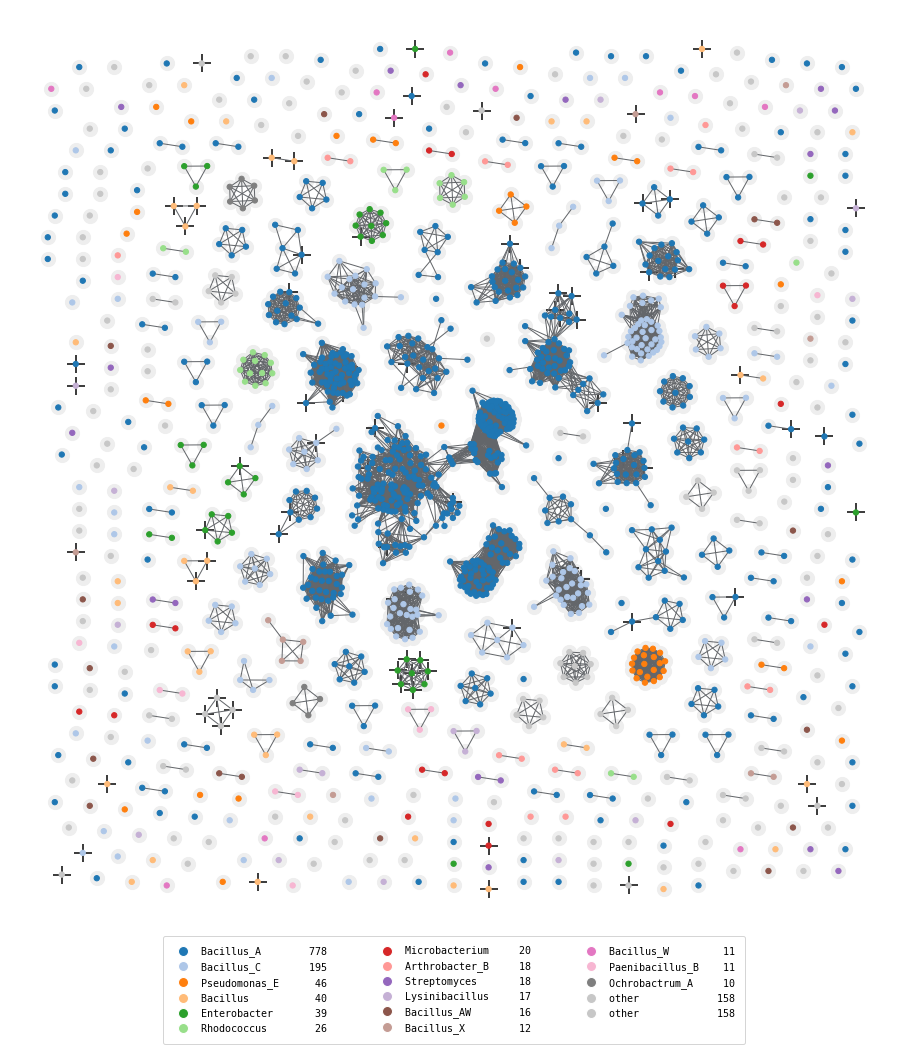

In [236]:
%%time
f, ax = plt.subplots()
f.set_size_inches(16, 17)
__ = ax.axis('off')
for i, r in pos_df.sort_values(by='size').iterrows():
    __ = ax.scatter(r[0], r[1], s=r['size'], c=r['back'], marker=r['marker'])

__ = nx.draw_networkx_edges(G, pos, ax=ax, edge_color='#63666a')
__ = ax.scatter(pos_df[0], pos_df[1], s=28, c=pos_df['color'], marker='o')

l1 = ax.legend(handles=legend_elements,
          bbox_to_anchor=(0.5, 0),
          loc='upper center',
          ncol=3,
          prop={'family': 'monospace'},
          columnspacing=5,
          borderpad=1)

In [225]:
f.savefig('../data/chlamy_threshold.png', dpi=600, transparent=False, facecolor='white')

In [237]:
clustresp = requests.post(
    url='https://sketch.api.agbiome.cloud/cluster',
    json=job_id
)

cluster_job_id = clustresp.json()

In [238]:
cluster_job_id

{'jobId': 'fcabbfc2-a861-41b6-99c7-a15fcf3860e6'}

In [240]:
cq = f'''
    select *
    from genomics.comparesketch_cluster
    where jobid = '{cluster_job_id['jobId']}'
'''

clust = ATHENA_CURSOR.execute(cq).as_pandas()

In [241]:
clust.head()

,sketch,cluster,threshold,tag,jobid
0,AIM050661_proj1_run83_20180330_plate529_H7_seq...,cluster10,85.0,383876aea6e4,fcabbfc2-a861-41b6-99c7-a15fcf3860e6
1,AIM051872_proj1_run86_20180430_plate542_H4_seq...,cluster10,85.0,383876aea6e4,fcabbfc2-a861-41b6-99c7-a15fcf3860e6
2,AIM051846_proj1_run86_20180430_plate542_E1_seq...,cluster10,85.0,383876aea6e4,fcabbfc2-a861-41b6-99c7-a15fcf3860e6
3,AIM051464_proj1_run85_20180409_plate538_C1_seq...,cluster10,85.0,383876aea6e4,fcabbfc2-a861-41b6-99c7-a15fcf3860e6
4,AIM050846_proj1_run83_20180330_plate531_B7_seq...,cluster10,85.0,383876aea6e4,fcabbfc2-a861-41b6-99c7-a15fcf3860e6


In [242]:
clust.groupby(['threshold'])['cluster'].nunique().reset_index()

,threshold,cluster
0,2.5,1194
1,5.9,1052
2,9.4,896
3,12.8,770
4,16.2,641
5,19.7,536
6,23.1,457
7,26.6,400
8,30.0,347
9,33.4,316


/tmp/ipykernel_139/866961938.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(l.get_text()))


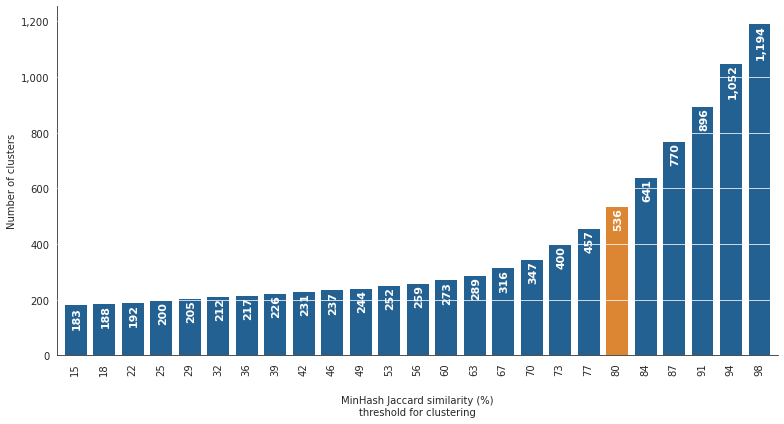

In [243]:
df_num_clusters = (
    clust
    .groupby('threshold')['cluster']
    .nunique()
    .to_frame()
    .reset_index()
    .rename(columns={'cluster': 'num_clusters'})
    .assign(cutoff = lambda df: 100 - df['threshold'])
    .drop('threshold', axis=1)
)

sns.set_style('white')

f, ax = plt.subplots()
f.set_size_inches(11,6)

barcolor = df_num_clusters['cutoff'].apply(lambda x: '#dc8633' if int(x)==80 else '#236192').tolist()
(
    df_num_clusters
    .plot(x='cutoff', y='num_clusters', kind='bar', ax=ax, width=0.8, color=barcolor)
)

plt.draw() # need this to set tick labels

ax.set_xlabel('MinHash Jaccard similarity (%)\nthreshold for clustering', labelpad=20)
ax.set_ylabel('Number of clusters')

ax.set_xlim(ax.get_xlim()[::-1])

ax.get_legend().set_visible(False)
ax.set_xticklabels(["{0:.0f}".format(float(l.get_text())) for l in ax.get_xticklabels()],
                   rotation = 90)
ax.set_yticklabels(['{:,}'.format(int(l.get_text())) 
                    if l.get_text() else '' 
                    for l in ax.get_yticklabels()])

for i, row in df_num_clusters.iterrows():
    color = 'white'
    y = row.num_clusters - 5
    va = 'top'
    fontweight = 'bold'
    ax.text(x = i + -0.065, 
            y = y, 
            s = "{:,}".format(int(row.num_clusters)),
            fontdict={'fontsize': 11,
                      'fontweight': fontweight,
                      'ha': 'center',
                      'va': va,
                      'rotation': '90',
                      'color': color})
        
sns.despine()

ax.grid(True, axis='y', color='#ffffff', linestyle='-', lw=0.75)
ax.set_axisbelow(False)

f.tight_layout()
f.savefig('../data/threshold_cluster_counts.png', dpi=600, transparent=True)